# Covid-19 Detection using X-ray images!

# Overview

Our project aimes to creat a solution that can easily detect covid-19 in an automated way, especialy when The need for auxiliary diagnostic tools has increased. This implementation use Keras with a TensorFlow backend, and it will be performed Then adapted to our dataset which is full of X-ray images in Covid-19 and No_findings folders.

### Import required libraries and necessary packages


In [1]:
from imutils import paths
import matplotlib.pyplot as plt
import numpy as np
import argparse
import os
import time
import keras
from sklearn.model_selection import train_test_split
from keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img
from keras.layers import AveragePooling2D, Dropout, Flatten, Dense, Input
from keras.models import Model, Sequential
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from sklearn.datasets import load_files
from sklearn.preprocessing import LabelBinarizer
from sklearn.metrics import classification_report, confusion_matrix

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
cd drive/My Drive/DL_capstron_project

/content/drive/My Drive/DL_capstron_project


In [ ]:
pwd

'/content/drive/MyDrive/DL_capstron_project'

## Load The data

In [4]:
from sklearn.datasets import load_files
data_dir=("/content/drive/MyDrive/DL_capstron_project/X-Ray Image DataSet")
#Loading Data
data = load_files(data_dir)

In [5]:
folders=os.listdir("/content/drive/MyDrive/DL_capstron_project/X-Ray Image DataSet")
print(folders)

['No_findings', 'Covid-19']


our data set, contains two folders, Covid-19 which contains X-ray images of people caught up with the virus, the No_findings which contains X-ray images of normal people

In [6]:
#Convert the data and labels to Numpy arrays
X = np.array(data['filenames'])
y = np.array(data['target'])
labels = np.array(data['target_names'])
 
# How the arrays look like?
print('Data files - ',X[0])
print('Target labels - ',y[0])
print('Number of training files : ', X.shape[0])
print('Number of training targets : ', y.shape[0])

Data files -  /content/drive/MyDrive/DL_capstron_project/X-Ray Image DataSet/No_findings/00003393_030.png
Target labels -  1
Number of training files :  640
Number of training targets :  640


## Convert images to arrays

In [7]:
def convert_img_to_arr(file_path_list):
    arr = []
    img_width, img_height = 150,150 
    #Loop over the image paths
    for file_path in file_path_list:
        """
           Load the image, swap color channels, and resize it to be a fixed
           150*150 pixels while ignoring aspect ratio
        """
        img = load_img(file_path, target_size = (img_width, img_height))
        img = img_to_array(img)
        
        #update the data
        arr.append(img)
    return arr
# Here our data is updated and it's stocked in the X array again !
X = np.array(convert_img_to_arr(X))

# The Data Shape
print(X.shape) 
print('First training item : ',X[0])

(640, 150, 150, 3)
First training item :  [[[  1.   1.   1.]
  [  1.   1.   1.]
  [  1.   1.   1.]
  ...
  [  1.   1.   1.]
  [  1.   1.   1.]
  [  1.   1.   1.]]

 [[  1.   1.   1.]
  [  1.   1.   1.]
  [  1.   1.   1.]
  ...
  [212. 212. 212.]
  [182. 182. 182.]
  [174. 174. 174.]]

 [[  1.   1.   1.]
  [  1.   1.   1.]
  [  1.   1.   1.]
  ...
  [245. 245. 245.]
  [214. 214. 214.]
  [178. 178. 178.]]

 ...

 [[162. 162. 162.]
  [163. 163. 163.]
  [165. 165. 165.]
  ...
  [157. 157. 157.]
  [158. 158. 158.]
  [187. 187. 187.]]

 [[161. 161. 161.]
  [163. 163. 163.]
  [166. 166. 166.]
  ...
  [159. 159. 159.]
  [162. 162. 162.]
  [185. 185. 185.]]

 [[161. 161. 161.]
  [167. 167. 167.]
  [166. 166. 166.]
  ...
  [158. 158. 158.]
  [164. 164. 164.]
  [187. 187. 187.]]]


## Few Take Aways
Note that the shape of training data is (625, 150, 150, 3)

625 is the number of training items or files,

(224,224) is the target size or image size provided while loading image

3 refers to the depth for colored images

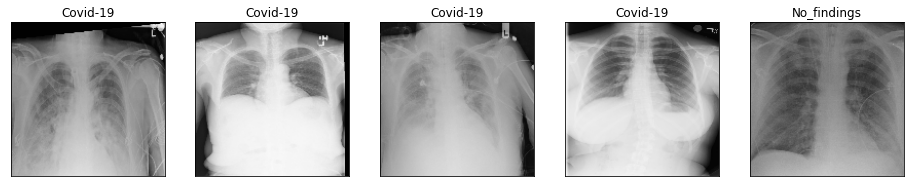

In [8]:
#Let's look at first 5 training data. 
fig = plt.figure(figsize = (16,9))
for i in range(5):
    ax = fig.add_subplot(1,5,i+1,xticks=[],yticks=[])
    ax.imshow((X[i].astype(np.uint8)))
    plt.title(folders[y[i]])

In [9]:
"""
   After that data is converted into Numpy array, Now, 
   Let's scale the pixel intenties to the range[0,255]
"""
X = X.astype('float32')/255

# Let's confirm the number of classes :) 
no_of_classes = len(np.unique(y))
no_of_classes

2

Our machine learning problem is a binary classification problem, we will detect whether a person is infected or not.

[ ]


In [10]:
y

array([1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 0,
       1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 0, 1, 1, 0, 1, 1,
       0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0,
       1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0,
       1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0,
       1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 0, 1, 0,
       1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1,
       0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1,
       1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1,

## Let's converts a class vector (integers) to binary class matrix

In [11]:
#from tensorflow.keras.utils import to_categorical
from tensorflow.keras.utils import to_categorical
from keras.utils import np_utils
""" 
let's converts a class vector (integers) to binary class matrix by performing the 
one-hot encoding on the labels
"""
y = np.array(np_utils.to_categorical(y,no_of_classes))
y[0]

array([0., 1.], dtype=float32)

# Split the data into train, test and valid subsets
Here we are going to split our dataset into 80% train, 10% validation, and 10% test.

In [13]:
# let's splite the data into subsets and explore their shapes !

X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2)
print('The train Data Shape ', X_train.shape[0])
 
X_test, X_valid, y_test, y_valid = train_test_split(X_test,y_test, test_size = 0.5)
print('The validation Data Shape ', X_valid.shape[0])
print('The test Data Shape ', X_test.shape[0])

The train Data Shape  512
The validation Data Shape  64
The test Data Shape  64


In [14]:
print('The train Data Shape ', X_train.shape[1:])

The train Data Shape  (150, 150, 3)


In [15]:
# Required libraries
import keras
from keras.models import Sequential
from keras.layers import Conv2D, MaxPool2D, Dense, Flatten, Dropout
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ReduceLROnPlateau

In [16]:
model = Sequential()

model.add(Conv2D(filters=32, kernel_size=(3,3), padding='same', input_shape=X_train.shape[1:], activation='relu', name='Conv2D_1'))
model.add(Conv2D(filters=32, kernel_size=(3,3), activation='relu', name='Conv2D_2'))
model.add(MaxPool2D(pool_size=(2,2), name='Maxpool_1'))
model.add(Dropout(0.25))

model.add(Conv2D(filters=64, kernel_size=(3,3), padding='same', activation='relu', name='Conv2D_3'))
model.add(Conv2D(filters=64, kernel_size=(3,3), activation='relu', name='Conv2D_4'))
model.add(MaxPool2D(pool_size=(2,2), name='Maxpool_2'))
model.add(Dropout(0.25))
    
model.add(Conv2D(filters=128, kernel_size=(3,3), padding='same', activation='relu', name='Conv2D_5'))
model.add(Conv2D(filters=128, kernel_size=(3,3), activation='relu', name='Conv2D_6'))
model.add(MaxPool2D(pool_size=(2,2), name='Maxpool_3'))

model.add(Flatten())
model.add(Dense(units=512, activation='relu', name='Dense_1'))
model.add(Dropout(0.5))
model.add(Dense(units=128, activation='relu', name='Dense_2'))
model.add(Dense(units=no_of_classes, activation='softmax', name='Output'))

# Compile the model

In [17]:
#from keras.optimizers import RMSprop
from tensorflow.keras.optimizers import Adam, SGD, RMSprop

optimizer = RMSprop(lr=0.001, rho=0.9, epsilon=1e-08, decay=0.0)

model.compile(optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

learning_rate_reduction=ReduceLROnPlateau(monitor='val_accuracy', patience = 3, verbose = 1, factor = 0.5, minlr = 0.00001)

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/rmsprop.py:130: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(RMSprop, self).__init__(name, **kwargs)


# Modelling

I am using model.fit_generator as I am using ImageDataGenerator to pass data to the model. I will pass train and valid data to fit_generator. In fit_generator steps_per_epoch will set the batch size to pass training data to the model and validation_steps will do the same for valid data. These settings could be changed according to each system specifications.

In [18]:
import time
from keras.callbacks import ModelCheckpoint, EarlyStopping
from keras.preprocessing.image import ImageDataGenerator


# Time to train our model !
epochs = 50
batch_size=32

train_datagen = ImageDataGenerator(
        rotation_range=10,  
        zoom_range = 0.1, 
        width_shift_range=0.1,
        height_shift_range=0.1,  
        horizontal_flip=True)

test_datagen = ImageDataGenerator()

train_generator = train_datagen.flow(
    X_train,y_train,
    batch_size=batch_size)

validation_generator = test_datagen.flow(
    X_valid,y_valid,
    batch_size=batch_size)

checkpointer = ModelCheckpoint("/drive/My Drive/DL_capstron_project/NouredAminaArcht.h5", save_best_only = True, verbose = 1)


start = time.time()

# let's get started !

history=model.fit_generator(train_generator,
                            epochs=epochs,
                            validation_data = validation_generator,
                            verbose=1,
                            steps_per_epoch=len(X_train) // batch_size,
                            validation_steps=len(X_valid) //batch_size,
                            callbacks=[checkpointer, learning_rate_reduction])

end = time.time()

duration = end - start
print ('\n This Model took %0.2f seconds (%0.1f minutes) to train for %d epochs'%(duration, duration/60, epochs) )

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:40: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.


Epoch 1/50
16/16 [==============================] - ETA: 0s - loss: 2.5119 - accuracy: 0.7520
Epoch 1: val_loss improved from inf to 0.59531, saving model to /drive/My Drive/DL_capstron_project/NouredAminaArcht.h5
16/16 [==============================] - 78s 5s/step - loss: 2.5119 - accuracy: 0.7520 - val_loss: 0.5953 - val_accuracy: 0.7031 - lr: 0.0010
Epoch 2/50
16/16 [==============================] - ETA: 0s - loss: 0.4727 - accuracy: 0.8164
Epoch 2: val_loss improved from 0.59531 to 0.58784, saving model to /drive/My Drive/DL_capstron_project/NouredAminaArcht.h5
16/16 [==============================] - 74s 5s/step - loss: 0.4727 - accuracy: 0.8164 - val_loss: 0.5878 - val_accuracy: 0.7031 - lr: 0.0010
Epoch 3/50
16/16 [==============================] - ETA: 0s - loss: 0.4337 - accuracy: 0.8164
Epoch 3: val_loss improved from 0.58784 to 0.55054, saving model to /drive/My Drive/DL_capstron_project/NouredAminaArcht.h5
16/16 [==============================] - 77s 5s/step - loss: 0.433

# Evaluation

In [19]:
 (eval_loss, eval_accuracy) = model.evaluate(  
     X_test, y_test, batch_size=batch_size, verbose=2)
 
print("Accuracy: {:.2f}%".format(eval_accuracy * 100)) 
print("Loss: {}".format(eval_loss))

2/2 - 2s - loss: 0.1365 - accuracy: 0.9688 - 2s/epoch - 1s/step
Accuracy: 96.88%
Loss: 0.13651612401008606


# accuracy = 96,88%
#  loss = 0.10685943067073822

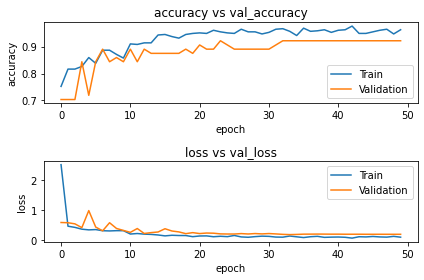

In [20]:
# Let's visualize the train/validation loss and accuracy wrt epochs

import matplotlib.pyplot as plt 
def plot(history):
    plt.figure(1) 
     # summarize history for accuracy  
 
    plt.subplot(211)  
    plt.plot(history.history['accuracy'])  
    plt.plot(history.history['val_accuracy'])  
    plt.title('accuracy vs val_accuracy')  
    plt.ylabel('accuracy')  
    plt.xlabel('epoch')  
    plt.legend(['Train', 'Validation'], loc='lower right')  
 
     # summarize history for loss  
 
    plt.subplot(212)  
    plt.plot(history.history['loss'])  
    plt.plot(history.history['val_loss'])  
    plt.title('loss vs val_loss')  
    plt.ylabel('loss')  
    plt.xlabel('epoch')  
    plt.legend(['Train', 'Validation'], loc='upper right')
    plt.tight_layout()
    plt.show()
 
# Finaly, let's call the plot function with the 'result' parameter 
 
plot(history)

From the Training and Validation Accuracy graph above, our model does not seem to be overfitted


Our Training and Validation Loss graph above also indicates a good learning rate,

# **Prediction**

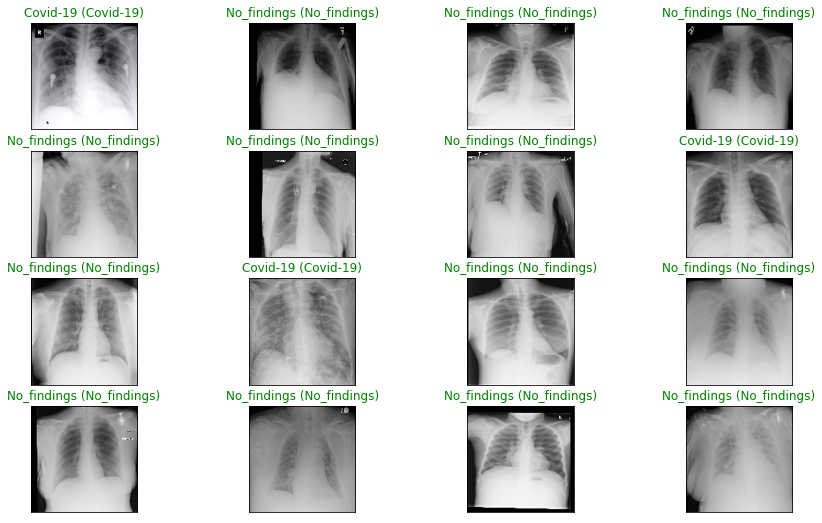

In [31]:
# Let's visualize some random test prediction.
def visualize_pred(y_pred):
# plot a random sample of test images, their predicted labels, and ground truth
    fig = plt.figure(figsize=(15, 9))
    for i, idx in enumerate(np.random.choice(X_test.shape[0], size=16, replace=False)):
        ax = fig.add_subplot(4, 4, i + 1, xticks=[], yticks=[])
        ax.imshow(np.squeeze(X_test[idx]))
        pred_idx = np.argmax(y_pred[idx])
        true_idx = np.argmax(y_test[idx])
        ax.set_title("{} ({})".format(labels[pred_idx], labels[true_idx]),
                     color=("green" if pred_idx == true_idx else "red"))

visualize_pred(model.predict(X_test))

# Confusion Matrix

Please note that, 0 and 1 values represent Covid-19 and No_findigs respectively .

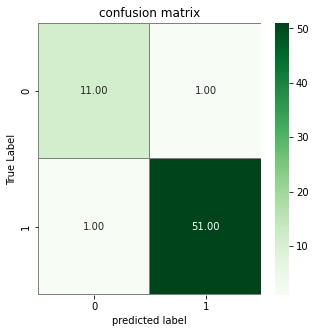

In [23]:
import seaborn as sns
from sklearn.metrics import confusion_matrix

Y_pred = model.predict(X_test)
Y_pred_classes = np.argmax(Y_pred,axis = 1)
Y_true = np.argmax(y_test,axis = 1)
confusion_mtx = confusion_matrix(Y_true,Y_pred_classes)
f,ax = plt.subplots(figsize = (5,5))
sns.heatmap(confusion_mtx,annot=True,linewidths = 0.01,cmap="Greens",
            linecolor = "gray",fmt = ".2f",ax=ax
            )
plt.xlabel("predicted label")
plt.ylabel("True Label")
plt.title("confusion matrix")
plt.show()

## You can check the classification report below for more information !

In [24]:
print(classification_report(y_test.argmax(axis=1),Y_pred_classes,  target_names= labels))

              precision    recall  f1-score   support

    Covid-19       0.92      0.92      0.92        12
 No_findings       0.98      0.98      0.98        52

    accuracy                           0.97        64
   macro avg       0.95      0.95      0.95        64
weighted avg       0.97      0.97      0.97        64



# Loading the model

In [25]:
my_model=keras.models.load_model("/drive/My Drive/DL_capstron_project/NouredAminaArcht.h5")

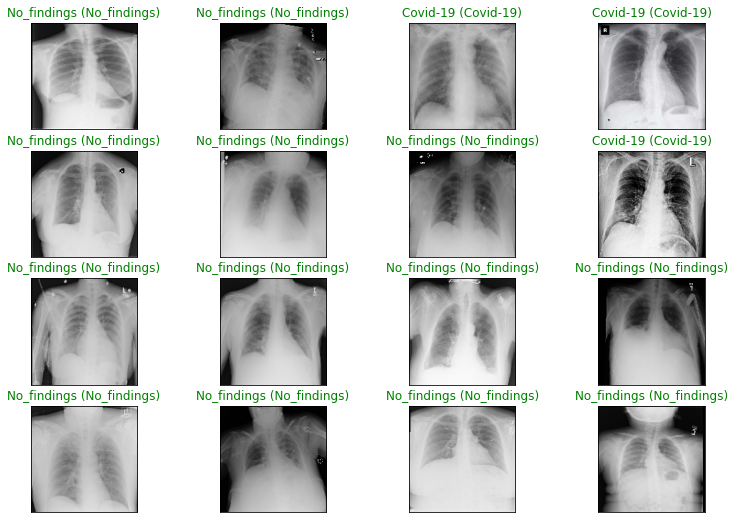

In [28]:
# Let's visualize some random test prediction.
def visualize_pred(y_pred):
# plot a random sample of test images, their predicted labels, and ground truth
    fig = plt.figure(figsize=(13, 9))
    for i, idx in enumerate(np.random.choice(X_test.shape[0], size=16, replace=False)):
        ax = fig.add_subplot(4, 4, i + 1, xticks=[], yticks=[])
        ax.imshow(np.squeeze(X_test[idx]))
        pred_idx = np.argmax(y_pred[idx])
        true_idx = np.argmax(y_test[idx])
        ax.set_title("{} ({})".format(labels[pred_idx], labels[true_idx]),
                     color=("green" if pred_idx == true_idx else "red"))

visualize_pred(my_model.predict(X_test))

# **Thank you a lot for your interest** ☻